In [1]:
import numpy as np
import pandas as pd
import cv2
from combine_databases import *
import matplotlib.pyplot as plt

In [2]:
# old_frame = cv2.imread('./database/CASME2/Cropped/sub01/EP02_01f/reg_img46_left_eye.jpg')

In [3]:
# old_frame = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
# old_frame = old_frame.astype(int)

In [4]:
# new_frame = cv2.imread('./database/CASME2/Cropped/sub01/EP02_01f/reg_img47_left_eye.jpg')
# new_frame = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
# new_frame = new_frame.astype(int)

In [2]:
def findMove(old_frame, new_frame):
    n = 7
    result = np.zeros([n, n])
    nRange = int((n - 1) / 2)
    r = min([old_frame.shape[0], new_frame.shape[0]])
    c = min([old_frame.shape[1], new_frame.shape[1]])
    for i in range(n):
        i = i - nRange
        for j in range(n):
            j = j - nRange
            if i < 0 and j < 0:
                result[i + nRange][j + nRange] = (new_frame[: r + i, : c + j] - old_frame[-i : r, -j : c]).std().round(3)
            if i < 0 and j >= 0:
                result[i + nRange][j + nRange] = (new_frame[: r + i, j : c] - old_frame[-i : r, : c - j]).std().round(3)
            if i >= 0 and j < 0:
                result[i + nRange][j + nRange] = (new_frame[i : r, : c + j] - old_frame[: r - i, -j : c]).std().round(3)
            if i >= 0 and j >= 0:
                result[i + nRange][j + nRange] = (new_frame[i : r, j : c] - old_frame[: r - i, : c - j]).std().round(3)
    return (int(result.argmin() / n) - nRange, int(result.argmin() % n) - nRange)

In [3]:
def maxPxGrid(frame, gridHeightNum, gridWidthNum):
    (h, w) = frame.shape
    m = int(h / gridHeightNum) + 1 
    n = int(w / gridWidthNum) + 1
    maxGrids = np.zeros([gridHeightNum, gridWidthNum]).astype(int)
    newGrid = np.zeros([m * gridHeightNum, n * gridWidthNum])
    newGrid[: h, : w] = frame
    for i in range(gridHeightNum):
        for j in range(gridWidthNum):
            maxGrids[i][j] = int(newGrid[i * m : (i + 1) * m, j * n : (j + 1) * n].max())
    return maxGrids

In [22]:
def focusArea(path, start, end, component, gridHeightNum, gridWidthNum, ifAbs):
    pre_frame = cv2.imread(path + str(start) + component)
    pre_frame = cv2.cvtColor(pre_frame, cv2.COLOR_BGR2GRAY)
    pre_frame = pre_frame.astype(int)
#     print(pre_frame.shape)
    r = pre_frame.shape[0]
    c = pre_frame.shape[1]
    gridDiff = np.zeros([gridHeightNum, gridWidthNum]).astype(int)
    gridDiffTem = np.zeros([gridHeightNum, gridWidthNum]).astype(int)
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    plt.figure(figsize=(15, 15))
    plotX = np.zeros([end - start, gridHeightNum, gridWidthNum])
    plotY = np.zeros([end - start, gridHeightNum, gridWidthNum])
    for i in range(end - start):
        new_image = cv2.imread(path + str(i + start + 1) + component)
        new_frame = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
        new_frame = new_frame.astype(int)
        pxMoved = findMove(pre_frame, new_frame)
        xDiff = pxMoved[0]
        yDiff = pxMoved[1]
        
        
        if xDiff < 0 and yDiff < 0:
            gridDiffTem = maxPxGrid(new_frame[: r + xDiff, : c + yDiff], gridHeightNum, gridWidthNum) - maxPxGrid(pre_frame[-xDiff : r, -yDiff : c], gridHeightNum, gridWidthNum)
        if xDiff < 0 and yDiff >= 0:
            gridDiffTem = maxPxGrid(new_frame[: r + xDiff, yDiff : c], gridHeightNum, gridWidthNum) - maxPxGrid(pre_frame[-xDiff : r, : c - yDiff], gridHeightNum, gridWidthNum)
        if xDiff >= 0 and yDiff < 0:
            gridDiffTem = maxPxGrid(new_frame[xDiff : r, : c + yDiff], gridHeightNum, gridWidthNum) - maxPxGrid(pre_frame[: r - xDiff, -yDiff : c], gridHeightNum, gridWidthNum)
        if xDiff >= 0 and yDiff >= 0:
            gridDiffTem = maxPxGrid(new_frame[xDiff : r, yDiff : c], gridHeightNum, gridWidthNum) - maxPxGrid(pre_frame[: r - xDiff, : c - yDiff], gridHeightNum, gridWidthNum)
        
        mask = np.zeros_like(new_image)
        maskColorDecide = (np.abs(gridDiffTem) > np.abs(gridDiffTem).max() / 2).astype(int) * gridDiffTem
        for mr in range(mask.shape[0]):
            for mc in range(mask.shape[1]):
                if (maskColorDecide[int(mr * gridHeightNum / mask.shape[0])][int(mc * gridWidthNum / mask.shape[1])] > 0):
                    mask[mr][mc] = [0, 255, 0]
                if (maskColorDecide[int(mr * gridHeightNum / mask.shape[0])][int(mc * gridWidthNum / mask.shape[1])] < 0):
                    mask[mr][mc] = [255, 0, 0]
#         print(np.resize(maskColorDecide, new_image.shape))
#         print(new_image.shape)
#         print(maskColorDecide.shape)
        gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
        test = np.stack((gray,)*3, axis=-1)
#         print(type(test))
#         print(type(new_image))
        img = cv2.add(test, mask)
#         b,g,r=cv2.split(img)
#         img = cv2.merge([r, g, b])
        plt.subplot(5, 5, i + 1, ).imshow(img)
#         print('l')
#         plt.imshow(img)
#         cv2.waitKey(0)
        plotY[i, :, :] = gridDiffTem
        plotX[i, :, :] = np.ones([gridHeightNum, gridWidthNum]) * i
        if ifAbs:
            gridDiff = gridDiff + np.abs(gridDiffTem)
        else:
            gridDiff = gridDiff + gridDiffTem
        
        pre_frame = new_frame
    plt.show()
    return plotX, plotY
#     return (gridDiff > gridDiff.max() / 2).astype(int)
#     print(gridDiffTem)

In [5]:
def paintAll(database, databaseName, emotions, gridHeightNum, gridWidthNum, ifAbs):
    fa = np.zeros([gridHeightNum, gridWidthNum])
    for i in range(len(database)):
        emotion = database['Emotion'][i]
        if not(emotion in emotions):
            continue
        if database.ApexFrame[i] == "/":
            continue
#         for j in range(int(database.ApexFrame[i]) - int(database.OnsetFrame[i]) + 1):
        imagePath, imageName = loadAllFile(database, databaseName, i, 0)
#             print(imagePath + imageName)
        fa = fa + focusArea(imagePath + imageName, int(database.OnsetFrame[i]), int(database.ApexFrame[i]), '.jpg', gridHeightNum, gridWidthNum, ifAbs)
#         print('finish ' + imagePath)
#     print((fa > np.median(fa)).astype(int) * fa)
    plt.imshow((fa > np.median(fa)).astype(int) * fa, cmap = 'gray')

<Figure size 432x288 with 0 Axes>

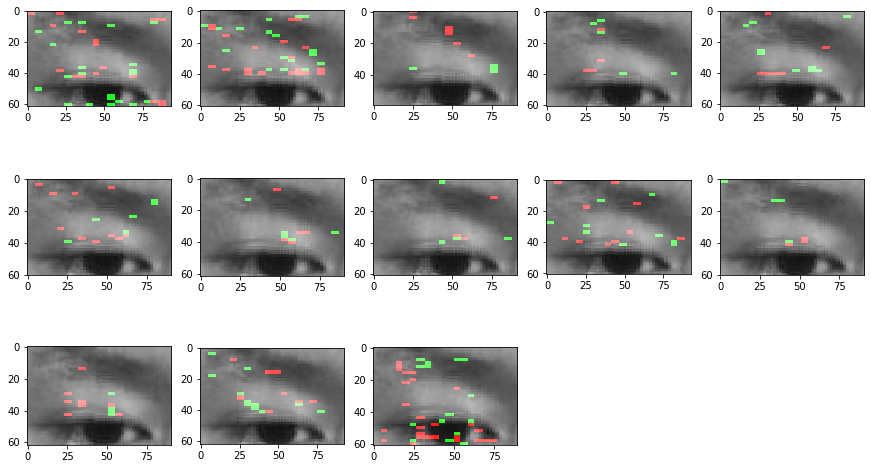

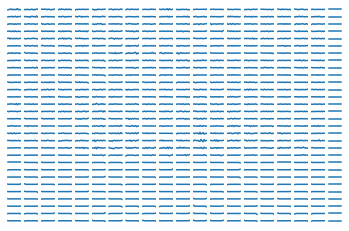

In [24]:
# casme2 = pd.read_csv('./database/CASME2/casme2.csv')
# paintAll(casme2, 'CASME2', ['happiness'], 30, 30, True)
# focusArea('./database/CASME2/Cropped/sub02/EP09_01/reg_img', 26, 56, '.jpg', 30, 30, True)
gridHeightNum = 30
gridWidthNum = 20
(plotX, plotY) = focusArea('./database/CASME2/Cropped/sub01/EP02_01f/reg_img', 46, 59, '_right_eye.jpg', gridHeightNum, gridWidthNum, True)
# plt.subplots_adjust(wspace=0.5,hspace=0.5)
# plt.figure(figsize=(60, 60))
fig, axs = plt.subplots(gridHeightNum, gridWidthNum)
plt.axis('off')
for i in range(gridHeightNum):
    for j in range(gridWidthNum):
        x = plotX[:, i, j]
        y = plotY[:, i, j]
        axs[i, j].plot(x, y)
        axs[i, j].set(ylim = [-40, 40])
        axs[i, j].set_axis_off()
plt.show()

In [6]:
# casme2 = pd.read_csv('./database/CASME2/casme2.csv')
# paintAll(casme2, 'CASME2', ['happiness'], 30, 30, True)
# focusArea('./database/CASME2/Cropped/sub02/EP09_01/reg_img', 26, 56, '.jpg', 30, 30, True)
gridHeightNum = 30
gridWidthNum = 20
(plotX, plotY) = focusArea('./database/CASME/Cropped/sub01/EP16_3/reg_EP16_3-', 53, 57, '_right_eye.jpg', gridHeightNum, gridWidthNum, True)
# plt.subplots_adjust(wspace=0.5,hspace=0.5)
# plt.figure(figsize=(60, 60))
fig, axs = plt.subplots(gridHeightNum, gridWidthNum)
plt.axis('off')
for i in range(gridHeightNum):
    for j in range(gridWidthNum):
        x = plotX[:, i, j]
        y = plotY[:, i, j]
        axs[i, j].plot(x, y)
        axs[i, j].set(ylim = [-40, 40])
        axs[i, j].set_axis_off()
plt.show()

error: OpenCV(4.1.1) c:\projects\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xe227985e::Set<1,-1,-1>,struct cv::impl::A0xe227985e::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


<Figure size 432x288 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 432x288 with 0 Axes>

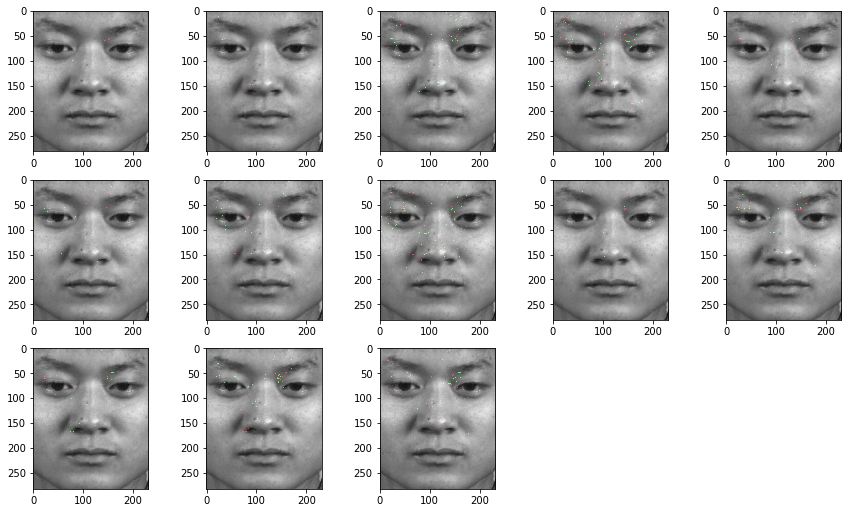

In [23]:
gridHeightNum = 200
gridWidthNum = 150
(plotX, plotY) = focusArea('./database/CASME2/Cropped/sub01/EP02_01f/reg_img', 46, 59, '.jpg', gridHeightNum, gridWidthNum, True)

<Figure size 432x288 with 0 Axes>

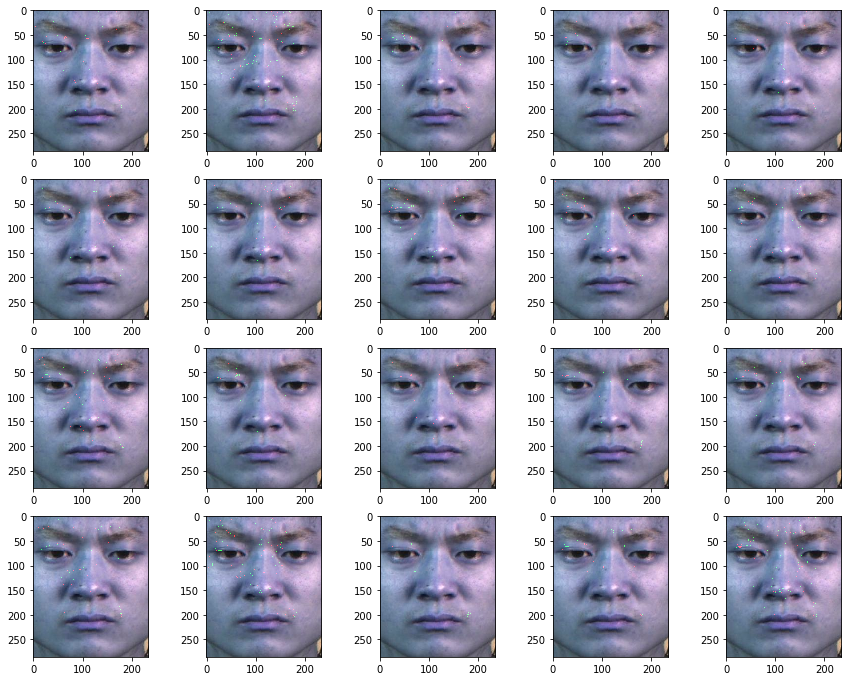

In [92]:
gridHeightNum = 200
gridWidthNum = 150
(plotX, plotY) = focusArea('./database/CASME2/Cropped/sub01/EP19_05f/reg_img', 396, 416, '.jpg', gridHeightNum, gridWidthNum, True)